In [5]:
%matplotlib inline
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn import svm
from scipy import signal
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
traindf = pd.read_csv('../data/train.csv', header = None)
valdf = pd.read_csv('../data/val.csv', header = None)
testdf = pd.read_csv('../data/test.csv', header = None)
print(len(testdf))

16200


### Loading raw data to train SVM

In [3]:
def return_segments(df):
    ''' Returns 2 arrays : 
        x of shape (num_examples, num_features = 150)
        y of shape (num_examples, num_classes = 5)
        Extracts this from given Pandas DataFrame
    '''
    x = np.zeros((len(df) // 150, 450))
    y = np.zeros((len(df) // 150, 5))
    for i in range(1, len(df) // 150) : 
        # taking 150 values of 3 channels at a time, flattening and 
        temp = df.iloc[(i - 1) * 150 : i * 150,  : 3].values
        x[i - 1] = np.transpose(temp).reshape(450)
        # finding single one_hot encoded label (which occurs maximum times in 150 values)
        label_array = df.iloc[((i - 1) * 150) : i * 150, 3 : ].values
        ind = np.argmax(np.sum(label_array, axis = 0))
        label = np.zeros_like(df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        y[i - 1] = label
        
    num = len(df) // 150
    # last example isn't considered in the loop
    temp = df.iloc[(num - 1) * 150 : , : 3].values
    x[num - 1] = np.transpose(temp).reshape(450)
    # just taking the central value for the last label
    y[num - 1] = df.iloc[((num - 1) * 150) + 75, 3 : ].values
    return x, y

# Calling loading function and load all data into NumPy arrays
# as required by sklearn
x_test, y_test_ = return_segments(testdf)
x_train, y_train_ = return_segments(traindf)
# Converting one_hot encoded labels to integers
y_test = np.argmax(y_test_, axis = 1)
y_train = np.argmax(y_train_, axis = 1)

# a = traindf.iloc[ : 150, : 3].values.reshape(450)
# b = traindf.iloc[150 : 300, : 3].values.reshape(450)
# x = np.zeros((len(traindf) // 150, 450))
# x[0] = a
# x[1] = b
# print(x.shape)

### Using Grid Search to find best hyperparameters for SVM

In [8]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(x_train, y_train)

/home/akshay/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [9]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
y_pred = final_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

Best score for training data: 0.4016393442622951 

Best C: 1 

Best Kernel: rbf 

Best Gamma: 0.001 

[[ 0  0  0 15  0]
 [ 0  0  0 19  0]
 [ 0  0  0 23  0]
 [ 0  0  0 33  0]
 [ 0  0  0 18  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        23
           3       0.31      1.00      0.47        33
           4       0.00      0.00      0.00        18

    accuracy                           0.31       108
   macro avg       0.06      0.20      0.09       108
weighted avg       0.09      0.31      0.14       108



/home/akshay/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
svm_lin = svm.SVC(kernel = 'rbf', C = 10, class_weight = 'balanced')
svm_lin.fit(x_train, y_train)
y_pred = svm_lin.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_pred = svm_lin.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

/home/akshay/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[ 3  2  5  4  1]
 [ 3  2  7  6  1]
 [ 0  1 18  3  1]
 [ 6  2 18  6  1]
 [ 5  4  6  1  2]]
              precision    recall  f1-score   support

           0       0.18      0.20      0.19        15
           1       0.18      0.11      0.13        19
           2       0.33      0.78      0.47        23
           3       0.30      0.18      0.23        33
           4       0.33      0.11      0.17        18

    accuracy                           0.29       108
   macro avg       0.26      0.28      0.24       108
weighted avg       0.27      0.29      0.25       108

[[ 36   6  48   7   2]
 [  5  46  24   7   5]
 [  9   7 127  22   6]
 [ 31  44 135 101  32]
 [ 18  21  49   9  57]]
              precision    recall  f1-score   support

           0       0.36      0.36      0.36        99
           1       0.37      0.53      0.44        87
           2       0.33      0.74      0.46       171
           3       0.69      0.29      0.41       343
           4       0.56      0.37

### Using only one channel data to train SVM

In [135]:
def return_segments_x_acc(df):
    ''' Returns 2 arrays : 
        x of shape (num_examples, num_features = 150)
        y of shape (num_examples, num_classes = 5)
        Extracts only x_acc data and labels from given Pandas DataFrame
    '''
    x = np.zeros((len(df) // 150, 150))
    y = np.zeros((len(df) // 150, 5))
    for i in range(1, len(df) // 150) : 
        # taking 150 values of 3 channels at a time, flattening and 
        x[i - 1] = df.iloc[(i - 1) * 150 : i * 150, 2].values
        # finding single one_hot encoded label (which occurs maximum times in 150 values)
        label_array = df.iloc[((i - 1) * 150) : i * 150, 3 : ].values
        ind = np.argmax(np.sum(label_array, axis = 0))
        label = np.zeros_like(df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        y[i - 1] = label
        
    num = len(df) // 150
    # last example isn't considered in the loop
    x[num - 1] = df.iloc[(num - 1) * 150 : , 0].values
    # just taking the central value for the last label
    y[num - 1] = df.iloc[((num - 1) * 150) + 75, 3 : ].values
    return x, y

xtrain, ytrain_ = return_segments_x_acc(traindf)
xtest, ytest_ = return_segments_x_acc(valdf)
ytest = np.argmax(ytest_, axis = 1)
ytrain = np.argmax(ytrain_, axis = 1)

In [136]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svm_model = GridSearchCV(SVC(class_weight = 'balanced'), params_grid, cv = 5)
svm_model.fit(xtrain, ytrain)

/home/akshay/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [137]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
y_pred = final_model.predict(xtest)
print(confusion_matrix(ytest, y_pred))
print(classification_report(ytest, y_pred))
y_pred = final_model.predict(xtrain)
print(confusion_matrix(ytrain, y_pred))
print(classification_report(ytrain, y_pred))

Best score for training data: 0.28337236533957844 

Best C: 100 

Best Kernel: linear 

Best Gamma: auto_deprecated 

[[ 3  2  4  4  2]
 [ 3  2  3  4  1]
 [ 5  2  9  3  0]
 [ 7  4 12  5  7]
 [ 5  6  4  5  4]]
              precision    recall  f1-score   support

           0       0.13      0.20      0.16        15
           1       0.12      0.15      0.14        13
           2       0.28      0.47      0.35        19
           3       0.24      0.14      0.18        35
           4       0.29      0.17      0.21        24

    accuracy                           0.22       106
   macro avg       0.21      0.23      0.21       106
weighted avg       0.23      0.22      0.21       106

[[ 76   0  14   7   2]
 [  0  72   6   8   1]
 [  7   4 134  23   3]
 [ 40  29  60 184  30]
 [ 11   6  16  10 111]]
              precision    recall  f1-score   support

           0       0.57      0.77      0.65        99
           1       0.65      0.83      0.73        87
           2       0.58

### Using 50 sampled points of signal as one example instead of 150 sampled points to increase the dataset size and train SVM using that larger dataset.

In [17]:
def return_segments(df):
    ''' Returns 2 arrays : 
        x of shape (num_examples, num_features = 50)
        y of shape (num_examples, num_classes = 5)
        Extracts this from given Pandas DataFrame
    '''
    x = np.zeros((len(df) // 50, 150))
    y = np.zeros((len(df) // 50, 5))
    for i in range(1, len(df) // 50) : 
        # taking 150 values of 3 channels at a time, flattening and 
        temp = df.iloc[(i - 1) * 50 : i * 50,  : 3].values
        x[i - 1] = np.transpose(temp).reshape(150)
        # finding single one_hot encoded label (which occurs maximum times in 150 values)
        label_array = df.iloc[((i - 1) * 50) : i * 50, 3 : ].values
        ind = np.argmax(np.sum(label_array, axis = 0))
        label = np.zeros_like(df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        y[i - 1] = label
        
    num = len(df) // 50
    # last example isn't considered in the loop
    temp = df.iloc[(num - 1) * 50 : , : 3].values
    x[num - 1] = np.transpose(temp).reshape(150)
    # just taking the central value for the last label
    y[num - 1] = df.iloc[((num - 1) * 50) + 25, 3 : ].values
    return x, y

# Calling loading function and load all data into NumPy arrays
# as required by sklearn
x_test, y_test_ = return_segments(testdf)
x_train, y_train_ = return_segments(traindf)
# Converting one_hot encoded labels to integers
y_test = np.argmax(y_test_, axis = 1)
y_train = np.argmax(y_train_, axis = 1)

In [142]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svm_model = GridSearchCV(SVC(), params_grid, cv = 5)
svm_model.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [143]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
y_pred = final_model.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_pred = final_model.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

Best score for training data: 0.4016393442622951 

Best C: 1 

Best Kernel: rbf 

Best Gamma: 0.001 

[[ 0  0  0 45  0]
 [ 0  0  0 57  0]
 [ 0  0  0 69  0]
 [ 0  0  0 99  0]
 [ 0  0  0 54  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.00      0.00      0.00        57
           2       0.00      0.00      0.00        69
           3       0.31      1.00      0.47        99
           4       0.00      0.00      0.00        54

    accuracy                           0.31       324
   macro avg       0.06      0.20      0.09       324
weighted avg       0.09      0.31      0.14       324



/home/akshay/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[   0    0    0  297    0]
 [   0    0    0  261    0]
 [   0    0    0  513    0]
 [   0    0    0 1029    0]
 [   0    0    0  462    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       297
           1       0.00      0.00      0.00       261
           2       0.00      0.00      0.00       513
           3       0.40      1.00      0.57      1029
           4       0.00      0.00      0.00       462

    accuracy                           0.40      2562
   macro avg       0.08      0.20      0.11      2562
weighted avg       0.16      0.40      0.23      2562



/home/akshay/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
# class_wt = {0 : 3, 1 : 3, 2 : 2, 3 : 1, 4 : 2}
svm_lin = svm.SVC(class_weight = 'balanced', kernel = 'rbf', decision_function_shape = 'ovr', C = 10, gamma = 'scale')
svm_lin.fit(x_train, y_train)
y_pred = svm_lin.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_pred = svm_lin.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[ 7  5 13 16  4]
 [ 9  3 13 24  8]
 [ 5  1 53  6  4]
 [ 1  3 42 42 11]
 [ 1  5 16 23  9]]
              precision    recall  f1-score   support

           0       0.30      0.16      0.21        45
           1       0.18      0.05      0.08        57
           2       0.39      0.77      0.51        69
           3       0.38      0.42      0.40        99
           4       0.25      0.17      0.20        54

    accuracy                           0.35       324
   macro avg       0.30      0.31      0.28       324
weighted avg       0.31      0.35      0.31       324

[[204   2  89   2   0]
 [  0 213  47   1   0]
 [  4   1 497   4   7]
 [ 32  16 309 659  13]
 [  5   7  92   7 351]]
              precision    recall  f1-score   support

           0       0.83      0.69      0.75       297
           1       0.89      0.82      0.85       261
           2       0.48      0.97      0.64       513
           3       0.98      0.64      0.77      1029
           4       0.95      0.76

After experimenting with SVMs trained on raw data, it is clear that even SVMs cannot generalize on raw data. So, will try to use running standard deviation, RMS, etc. before feeding to SVM.

### Using running standard deviation data to train SVM

In [26]:
def running_std_deviation(x, window_size = 10):
    ''' Returns running standard deviation of x calculated using a window of size window_size
    Sliding of window starts from zero index upto where window can be placed (len(x) - window_size)
    Remaining part of input is discarded (not very significant since it will be present in some other
    input also due to the 50% overlap)
    '''
    std_dev = np.zeros(len(x) - window_size)
    for i in range(len(x) - window_size):
        std_dev[i] = np.std(x[i : i + window_size])
        
    return std_dev

def return_segments(df, window_size = 20):
    ''' Returns 2 arrays : 
        x of shape (num_examples, num_features = 150)
        y of shape (num_examples, num_classes = 5)
        Extracts this from given Pandas DataFrame
    '''
    x = np.zeros((len(df) // 150, 450 - (3 * window_size)))
    y = np.zeros((len(df) // 150, 5))
    for i in range(1, len(df) // 150) : 
        # taking 150 values of 3 channels at a time, flattening and 
        acc = df.iloc[(i - 1) * 150 : i * 150,  : 3].values
        z = np.zeros(450 - (3 * window_size))
        z[0 : 150 - window_size] = running_std_deviation(np.transpose(acc)[0], window_size = window_size)
        z[150 - window_size : 300 - (2 * window_size)] = running_std_deviation(np.transpose(acc)[1], window_size = window_size)
        z[300 - (2 * window_size) : ] = running_std_deviation(np.transpose(acc)[2], window_size = window_size)
        x[i - 1] = z
        # finding single one_hot encoded label (which occurs maximum times in 150 values)
        label_array = df.iloc[((i - 1) * 150) : i * 150, 3 : ].values
        ind = np.argmax(np.sum(label_array, axis = 0))
        label = np.zeros_like(df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        y[i - 1] = label
        
    num = len(df) // 150
    # last example isn't considered in the loop
    acc = df.iloc[(num - 1) * 150 : , : 3].values
    z = np.zeros(450 - (3 * window_size))
    z[0 : 150 - window_size] = running_std_deviation(np.transpose(acc)[0], window_size = window_size)
    z[150 - window_size : 300 - (2 * window_size)] = running_std_deviation(np.transpose(acc)[1], window_size = window_size)
    z[300 - (2 * window_size) : ] = running_std_deviation(np.transpose(acc)[2], window_size = window_size)
    x[num - 1] = z
    # just taking the central value for the last label
    y[num - 1] = df.iloc[((num - 1) * 150) + 75, 3 : ].values
    return x, y

# Calling loading function and load all data into NumPy arrays
# as required by sklearn
x_test, y_test_ = return_segments(testdf)
x_train, y_train_ = return_segments(traindf)
# Converting one_hot encoded labels to integers
y_test = np.argmax(y_test_, axis = 1)
y_train = np.argmax(y_train_, axis = 1)

In [201]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svm_model = GridSearchCV(SVC(class_weight = 'balanced'), params_grid, cv = 5)
svm_model.fit(x_train, y_train)

/home/akshay/anaconda3/envs/pyt/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [202]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
y_pred = final_model.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_pred = final_model.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

Best score for training data: 0.30327868852459017 

Best C: 1000 

Best Kernel: rbf 

Best Gamma: 0.001 

[[ 5  5  3  1  1]
 [ 4  7  3  4  1]
 [ 1  0 20  1  1]
 [12  4  8  5  4]
 [ 3  4  3  3  5]]
              precision    recall  f1-score   support

           0       0.20      0.33      0.25        15
           1       0.35      0.37      0.36        19
           2       0.54      0.87      0.67        23
           3       0.36      0.15      0.21        33
           4       0.42      0.28      0.33        18

    accuracy                           0.39       108
   macro avg       0.37      0.40      0.36       108
weighted avg       0.38      0.39      0.36       108

[[ 41   6  37   8   7]
 [ 13  43  14   6  11]
 [ 21  11 118   8  13]
 [ 78  41  91  78  55]
 [ 21  24  23  10  76]]
              precision    recall  f1-score   support

           0       0.24      0.41      0.30        99
           1       0.34      0.49      0.41        87
           2       0.42      0.69  

In [206]:
# class_wt = {0 : 3, 1 : 3, 2 : 2, 3 : 1, 4 : 2}
svm_lin = svm.SVC(class_weight = 'balanced', kernel = 'linear', C = 10)
svm_lin.fit(x_train, y_train)
y_pred = svm_lin.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_pred = svm_lin.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[ 3  6  3  2  1]
 [ 4  5  3  4  3]
 [ 1  1 18  2  1]
 [11  4  8  6  4]
 [ 5  4  2  3  4]]
              precision    recall  f1-score   support

           0       0.12      0.20      0.15        15
           1       0.25      0.26      0.26        19
           2       0.53      0.78      0.63        23
           3       0.35      0.18      0.24        33
           4       0.31      0.22      0.26        18

    accuracy                           0.33       108
   macro avg       0.31      0.33      0.31       108
weighted avg       0.33      0.33      0.32       108

[[ 51   5  33   6   4]
 [  8  56  12   3   8]
 [ 24   5 118  10  14]
 [ 79  48  82  87  47]
 [ 22  19  16  13  84]]
              precision    recall  f1-score   support

           0       0.28      0.52      0.36        99
           1       0.42      0.64      0.51        87
           2       0.45      0.69      0.55       171
           3       0.73      0.25      0.38       343
           4       0.54      0.55

### Obtaining low pass filtered (LPF) data

In [71]:
# Required functions for implementing Butterworth 4th order low pass filter
# Source : https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
def butter_lowpass(cutoff, nyq_freq, order = 4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def return_processed_segments(x, cutoff_freq = 5.0, sample_rate = 50.0) :
    ''' Returns low pass filtered segments. Input should be NumPy array of segments.
    '''
    i = 0
    x_lpf = np.zeros_like(x)
    for x2 in x :
        x_lpf[i,  : 150] = butter_lowpass_filter(x2[ : 150], 5, 50 // 2)
        x_lpf[i, 150 : 300] = butter_lowpass_filter(x2[150 : 300], 5, 50 // 2)
        x_lpf[i, 300 : ] = butter_lowpass_filter(x2[300 : ], 5, 50 // 2)
        i = i + 1
    
    return x_lpf
    
x_train_lpf = return_processed_segments(x_train)
x_test_lpf = return_processed_segments(x_test)

#### Checking correctness of LPF

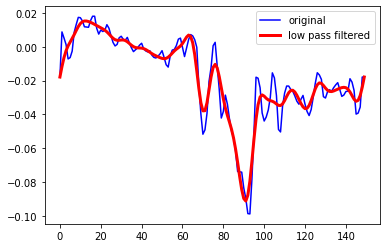

In [70]:
fig, axes = plt.subplots()
axes.plot(x_train[352, 150 : 300], 'b', label = 'original')
axes.plot(x_train_lpf[352, 150 : 300], 'r', label = 'low pass filtered', linewidth = 3)
axes.legend()

In [83]:
# class_wt = {0 : 3, 1 : 3, 2 : 2, 3 : 1, 4 : 2}
svm_lin = svm.SVC(kernel = 'rbf', C = 10, gamma = 'scale')
svm_lin.fit(x_train_lpf, y_train)
y_pred = svm_lin.predict(x_test_lpf)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_pred = svm_lin.predict(x_train_lpf)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[ 1  0  4  9  1]
 [ 2  1  3 11  2]
 [ 1  0 15  6  1]
 [ 2  1  8 21  1]
 [ 2  0  5  6  5]]
              precision    recall  f1-score   support

           0       0.12      0.07      0.09        15
           1       0.50      0.05      0.10        19
           2       0.43      0.65      0.52        23
           3       0.40      0.64      0.49        33
           4       0.50      0.28      0.36        18

    accuracy                           0.40       108
   macro avg       0.39      0.34      0.31       108
weighted avg       0.40      0.40      0.35       108

[[ 82   0  17   0   0]
 [  0  75   8   3   1]
 [  1   0 165   3   2]
 [  0   0  30 313   0]
 [  0   0   9   3 142]]
              precision    recall  f1-score   support

           0       0.99      0.83      0.90        99
           1       1.00      0.86      0.93        87
           2       0.72      0.96      0.82       171
           3       0.97      0.91      0.94       343
           4       0.98      0.92

In [94]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-1, 1e-2, 1e-3, 1e-4],
                     'C': [100, 1000, 1e4, 1e5]}]

svm_model = GridSearchCV(SVC(class_weight = 'balanced'), params_grid, cv = 10, iid = False)
svm_model.fit(x_train_lpf, y_train)

# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
y_pred = final_model.predict(x_test_lpf)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_pred = final_model.predict(x_train_lpf)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

Best score for training data: 0.3570143528504786 

Best C: 100 

Best Kernel: rbf 

Best Gamma: 0.1 

[[ 2  0  2  9  2]
 [ 3  2  2 11  1]
 [ 2  3 12  5  1]
 [ 3  5  7 17  1]
 [ 2  1  4  8  3]]
              precision    recall  f1-score   support

           0       0.17      0.13      0.15        15
           1       0.18      0.11      0.13        19
           2       0.44      0.52      0.48        23
           3       0.34      0.52      0.41        33
           4       0.38      0.17      0.23        18

    accuracy                           0.33       108
   macro avg       0.30      0.29      0.28       108
weighted avg       0.32      0.33      0.31       108

[[ 96   0   3   0   0]
 [  0  87   0   0   0]
 [  2   2 164   0   3]
 [  3   5  23 310   2]
 [  0   1   3   0 150]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        99
           1       0.92      1.00      0.96        87
           2       0.85      0.96      

Even using low pass filters, the SVM still overfits the training data and fails to generalize. This could be because low pass filter gives output kind of similar to `running_mean`. Need to try other things.

In [16]:
from sklearn.ensemble import RandomForestClassifier
# class_wt = {0 : 3, 1 : 3, 2 : 2, 3 : 1, 4 : 2}
svm_lin = RandomForestClassifier(n_estimators = 10)
svm_lin.fit(x_train, y_train)
y_pred = svm_lin.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_pred = svm_lin.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[ 0  1  4  9  1]
 [ 3  1  1 11  3]
 [ 1  0 10 12  0]
 [ 1  1  6 23  2]
 [ 3  0  2 12  1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.33      0.05      0.09        19
           2       0.43      0.43      0.43        23
           3       0.34      0.70      0.46        33
           4       0.14      0.06      0.08        18

    accuracy                           0.32       108
   macro avg       0.25      0.25      0.21       108
weighted avg       0.28      0.32      0.26       108

[[ 98   0   1   0   0]
 [  0  82   0   3   2]
 [  0   0 164   7   0]
 [  1   2   4 334   2]
 [  0   0   4   4 146]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        99
           1       0.98      0.94      0.96        87
           2       0.95      0.96      0.95       171
           3       0.96      0.97      0.97       343
           4       0.97      0.95